# Partial Least Squares

### Import necessary modules for PLS

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RepeatedKFold, train_test_split, GridSearchCV, learning_curve, KFold

### Load dataframe

In [2]:
df_data = pd.read_csv("df_1hot.csv")
Y = df_data.iloc[:, 0]
X = df_data.iloc[:, 1 :]

n, p = X.shape
print(f"Shape of X: {n} samples, {p} features")
X.head(3)

Shape of X: 100 samples, 116 features


,x_01,x_02,x_03,x_04,x_05,x_06,x_07,x_08,x_09,x_10,...,C_04_0.0,C_04_1.0,C_04_2.0,C_04_3.0,C_04_4.0,C_05_0.0,C_05_1.0,C_05_2.0,C_05_3.0,C_05_4.0
0,1.320635,-1.245359,0.580798,-0.208784,0.879537,-0.147866,-1.384418,-0.098386,0.973221,-1.825075,...,0,0,1,0,0,0,0,1,0,0
1,0.379658,0.877093,0.371622,1.057238,0.739473,1.797215,-0.031937,0.119855,1.822758,0.719912,...,0,0,1,0,0,0,0,1,0,0
2,0.910528,-0.683362,0.990018,0.436947,0.426031,-0.335860,-1.540555,0.132341,0.670108,0.577881,...,0,0,0,1,0,0,0,0,1,0


### Imputing missing values

In [3]:
def fill_NaNs_KNN(dataframe):
    X_cat = dataframe[[col for col in dataframe.columns if col.startswith('C_')]]
    X_cont = dataframe[[col for col in dataframe.columns if col.startswith('x_')]]

    ### 1. Fill NaN vlaues in continuous columns (X_cont)
    scaler = StandardScaler()
    scaled_X_cont = scaler.fit_transform(X_cont)
    knn_imputer = KNNImputer(n_neighbors=5)
    X_cont_imputed = knn_imputer.fit_transform(scaled_X_cont)
    X_cont_imputed = pd.DataFrame(X_cont_imputed, columns=X_cont.columns)

    ### 2. Fill NaN vlaues for the categorical columns (X_cat)
    #cat_imputer = SimpleImputer(strategy="most_frequent")
    #X_cat_imputed = cat_imputer.fit_transform(X_cat)
    #X_cat_imputed = pd.DataFrame(X_cat_imputed, columns=X_cat.columns)

    ### 4. 1-HOT-encoding of categorical columns
    #X_cat_imputed_1HOT = pd.get_dummies(X_cat_imputed, columns=X_cat_imputed.columns, drop_first=False).astype(int)
    
    ### 5. Merging y, X_con_imputed (standartized and NaN filled) and X_con_imputed_1HOT (NaN filled and relabelled, 1hotencoded)
    df_trans = pd.concat([X_cont_imputed.reset_index(drop=True), X_cat.reset_index(drop=True)], axis=1)

    return df_trans, df_trans.shape, scaler

def centerData_y(y):
    
    y_mu = np.mean(y,axis=0)
    y_centr = y - y_mu
    
    return y_centr, y_mu

def cont_cat(dataframe):
    X_cat = dataframe[[col for col in dataframe.columns if col.startswith('C_')]]
    X_cont = dataframe[[col for col in dataframe.columns if col.startswith('x_')]]

    return X_cont, X_cat

def align_columns(Xtrain, Xtest):
    # Find columns in Xtrain and Xtest
    missing_in_Xtrain = set(Xtest.columns) - set(Xtrain.columns)
    missing_in_Xtest = set(Xtrain.columns) - set(Xtest.columns)
    
    # Add missing columns to the respective DataFrames
    for col in missing_in_Xtrain:
        Xtrain[col] = np.nan  # or you can use 0 if preferred
    
    for col in missing_in_Xtest:
        Xtest[col] = np.nan  # or you can use 0 if preferred

    # Ensure columns are in the same order
    Xtrain = Xtrain[Xtest.columns]

    return Xtrain, Xtest

### Data split

In [4]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2,  random_state=42)

"""
# Handle missing values
Xtrain, shape, scaler = fill_NaNs_KNN(Xtrain)

# Preprocess test set using the same transformations
X_cont, X_cat = cont_cat(Xtest)
X_cont = pd.DataFrame(scaler.transform(X_cont), columns=X_cont.columns)
Xtest = pd.concat([X_cont.reset_index(drop=True), X_cat.reset_index(drop=True)], axis=1)
Xtest, ___, ___  = fill_NaNs_KNN(Xtest)

# Center the target variable
ytrain, y_mu = centerData_y(ytrain)
ytest = ytest - y_mu
"""

'\n# Handle missing values\nXtrain, shape, scaler = fill_NaNs_KNN(Xtrain)\n\n# Preprocess test set using the same transformations\nX_cont, X_cat = cont_cat(Xtest)\nX_cont = pd.DataFrame(scaler.transform(X_cont), columns=X_cont.columns)\nXtest = pd.concat([X_cont.reset_index(drop=True), X_cat.reset_index(drop=True)], axis=1)\nXtest, ___, ___  = fill_NaNs_KNN(Xtest)\n\n# Center the target variable\nytrain, y_mu = centerData_y(ytrain)\nytest = ytest - y_mu\n'

### PLS

Mean Squared Error: 2012.0572221255547
R-squared: 0.6916678555534304
Root Mean Squared Error: 44.855960831594665


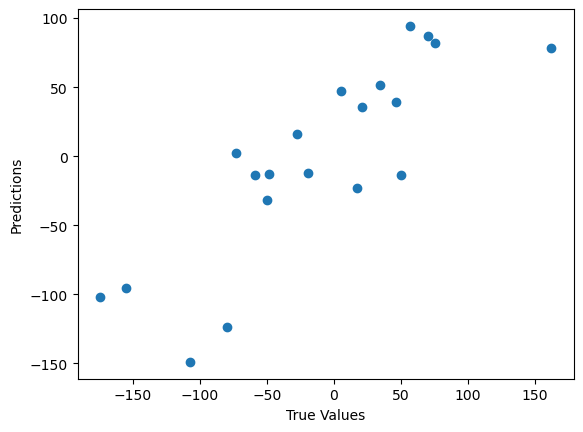

In [5]:
# Uncomment and adjust the preprocessing steps as needed
# Handle missing values
Xtrain, shape, scaler = fill_NaNs_KNN(Xtrain)

# Preprocess test set using the same transformations
X_cont, X_cat = cont_cat(Xtest)
X_cont = pd.DataFrame(scaler.transform(X_cont), columns=X_cont.columns)
Xtest = pd.concat([X_cont.reset_index(drop=True), X_cat.reset_index(drop=True)], axis=1)
Xtest, ___, ___  = fill_NaNs_KNN(Xtest)

# Center the target variable
ytrain, y_mu = centerData_y(ytrain)
ytest = ytest - y_mu

# Align columns in training and testing sets
Xtrain, Xtest = align_columns(Xtrain, Xtest)

# Initialize and fit the PLS model
pls = PLSRegression(n_components=4)  # Choose the number of components
pls.fit(Xtrain, ytrain)

# Make predictions
y_pred = pls.predict(Xtest)

# Evaluate the model
mse = mean_squared_error(ytest, y_pred)
r2 = r2_score(ytest, y_pred)
rmse = root_mean_squared_error(ytest, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')
print(f'Root Mean Squared Error: {rmse}')

# Plot the results
plt.scatter(ytest, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.show()

In [23]:
np.arange(1,100,1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

Best parameters for Ridge:  {'n_components': 4}
Best cross-validation score: 0.4852
R² Score on the test dataset: 0.6866
MSE on the test dataset: 2045.0896
RMSE on the test dataset: 45.2227


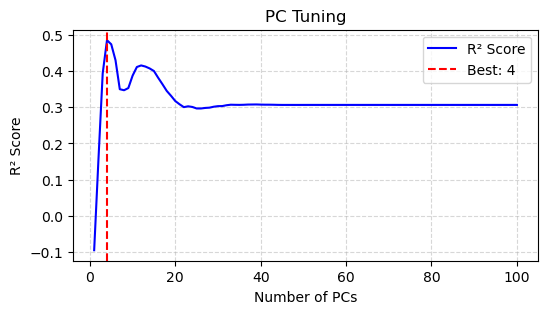

Best estimator: PLSRegression(n_components=4)


In [30]:
# Split the data
Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialize and fit the PLS model
pls = PLSRegression(n_components=4)  # Choose the number of components
#pls.fit(Xtrain, ytrain)

# Define the hyperparameter grid for alpha
param_pls_pc = {
    'n_components': np.arange(1,101,1)
    }

# Define KFold cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)
#cv = LeaveOneOut()

# Use GridSearchCV with the KFold object
PLS_ = GridSearchCV(pls, param_pls_pc, cv=cv, n_jobs=-1, return_train_score=True, scoring='r2')

# Fit the GridSearchCV
PLS_.fit(Xtrain, ytrain)

# Print best parameters and best cross-validation score
print("Best parameters for Ridge: ", PLS_.best_params_)
print("Best cross-validation score: {:.4f}".format(PLS_.best_score_))

# Evaluate the best model on the test data
best_model_ridge = PLS_.best_estimator_
y_pred_pls = best_model_ridge.predict(Xtest)

# Calculate R² score on test set
test_R2 = r2_score(ytest, y_pred_pls)
test_MSE = mean_squared_error(ytest, y_pred_pls)
test_RMSE = root_mean_squared_error(ytest, y_pred_pls)

print("R² Score on the test dataset: {:.4f}".format(test_R2))
print("MSE on the test dataset: {:.4f}".format(test_MSE))
print("RMSE on the test dataset: {:.4f}".format(test_RMSE))

# Get the mean test scores from the cross-validation results
n_components = np.arange(1,101,1)
mean_test_scores = PLS_.cv_results_['mean_test_score']

# Plot the results of hyperparameter tuning
plt.figure(figsize=(6, 3))
plt.plot(n_components, mean_test_scores, linestyle='-', color='b', label='R² Score')
plt.axvline(PLS_.best_params_['n_components'], color='r', linestyle='--', label=f"Best: {PLS_.best_params_['n_components']}")
plt.xlabel('Number of PCs')
plt.ylabel('R² Score')
plt.title('PC Tuning')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Print best estimator
print(f'Best estimator: {PLS_.best_estimator_}')